In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hypertools as hyp
import quail
from scipy.stats import pearsonr as corr
from scipy.signal import resample

%matplotlib inline
sns.set_context('poster')
plt.rc('figure', figsize=(12, 8))

In [2]:
rawdir = '../../data/raw/'
datadir = '../../data/processed/'

In [3]:
# load in raw annotation file
movie_annotations = pd.read_excel(rawdir+'Sherlock_Segments_1000_NN_2017.xlsx')
movie_annotations['Scene Segments'].fillna(method='ffill', inplace=True)

In [4]:
# model parameters
ntopics = 100
m_wsize = 50

# vectorizer parameters
vectorizer = {
    'model' : 'CountVectorizer', 
    'params' : {
        'stop_words' : 'english'
    }
}

# topic model parameters
semantic = {
    'model' : 'LatentDirichletAllocation', 
    'params' : {
        'n_components' : ntopics,
        'learning_method' : 'batch',
        'random_state' : 0
    }
}

## define some functions

In [5]:
# train a topic model on text samples from the scene annotations
def model_movie(movie_df, w_size, vec_params, sem_params):

    # create list of text samples from annotations
    movie_text = movie_df.apply(lambda x: ','.join(x.fillna('')), axis=1).values.tolist()
    
    # create sliding window of text samples
    movie_windows = []
    for idx, sentence in enumerate(movie_text):
        movie_windows.append(','.join(movie_text[idx:idx+m_wsize]))

    # vectorizer and topic model parameters
    vectorizer = vec_params
    semantic = sem_params

    # use hypertools to create movie model
    movie_model = hyp.tools.format_data(movie_windows, vectorizer=vec_params, semantic=sem_params, corpus=movie_windows)[0]

    # scene description are by shot, not TR, so stretch the model to be in TRs
    ranges =[[d['Start Time (TRs, 1.5s)'],d['End Time (TRs, 1.5s)']] for i, d in movie_annotations.iterrows()] 
    expanded = []
    for i in range(1976):
        try:
            idx = np.where([i>=r[0] and i<=r[1] for r in ranges])[0][0]
            expanded.append(movie_model[idx, :])
        except:
            expanded.append(movie_model[0, :])
    
    # make movie windows accessible for modeling recall
    return np.array(expanded)

In [6]:
# drop a single feature from the model
def drop_feature(df, feature):
    return df.drop(feature, axis=1)

# computes correlation between movie models and standard error
def compare_m_models(model1, model2):
    r = corr(pd.DataFrame(model1).T.corr().values.ravel(), pd.DataFrame(model2).T.corr().values.ravel())[0]
    dof = len(pd.DataFrame(model1).T.corr().values.ravel()) - 2
    se = np.sqrt((1-r**2)/dof)
    return r, se

## which features are important to movie model structure?

In [7]:
# isolate features used in model
features_df = movie_annotations.loc[:,'Scene Details - A Level ':'Words on Screen ']
features_df.columns = ['Narrative Details', 'Indoor vs Outdoor', 'Characters on Screen', 'Character in Focus', 'Character Speaking', 'Setting', 'Camera Angle', 'Music Presence', 'Text on Screen']

In [8]:
# load in full movie model
full_movie_model = np.load(datadir+'models_t100_v50_r10_resampled.npy')[0]

In [9]:
dropfeat_corr = {}
standard_errors = {}

# iteratively leave out one feature from the model 
for feat in features_df.columns:
    print('\ndropping '+str(feat))
    partial_df = drop_feature(features_df,feat)
    
    # compute partial movie model
    print('computing movie model')
    partial_movie_model = model_movie(partial_df, m_wsize, vectorizer, semantic)
    
    # correlate to full model
    model_stats = compare_m_models(partial_movie_model, full_movie_model)
    model_corr = model_stats[0]
    model_se = model_stats[1]
    print('model correlation is '+ str(model_corr))
    print('model standard error is '+ str(model_se))
    dropfeat_corr[feat] = model_corr
    standard_errors[feat] = model_se


dropping Narrative Details
computing movie model
model correlation is 0.816999416619916
model standard error is 0.00029182117515137495

dropping Indoor vs Outdoor
computing movie model
model correlation is 0.8766734235574367
model standard error is 0.00024346462096428546

dropping Characters on Screen
computing movie model
model correlation is 0.8852409813813537
model standard error is 0.00023539108988875253

dropping Character in Focus
computing movie model
model correlation is 0.9471895100684966
model standard error is 0.00016228462633181303

dropping Character Speaking
computing movie model
model correlation is 0.8748901536160689
model standard error is 0.00024510198616743234

dropping Setting
computing movie model
model correlation is 0.906258567201294
model standard error is 0.0002139291023474448

dropping Camera Angle
computing movie model
model correlation is 0.8927190384602313
model standard error is 0.00022804343544360518

dropping Music Presence
computing movie model
model c

## plot correlations with full model

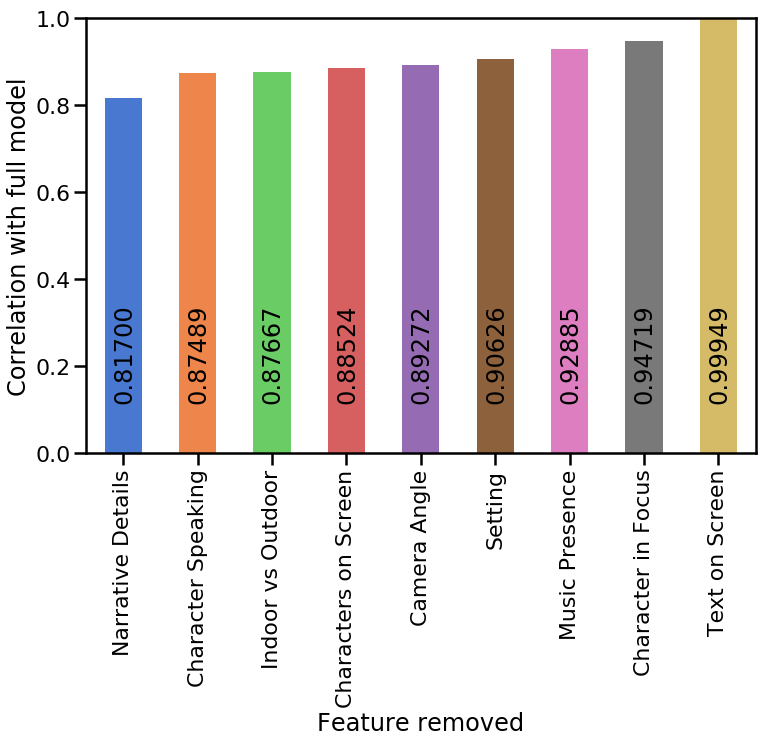

In [19]:
sns.set_palette('muted')
order = ['None','Narrative Details','Music Presence', 'Setting','Character Speaking','Text on Screen',
                 'Indoor vs Outdoor','Character in Focus','Characters on Screen','Camera Angle']

series_ord = pd.Series(dropfeat_corr).sort_values()
series_ord.plot(kind='bar', ylim=[0,1], yerr=standard_errors)
plt.ylabel('Correlation with full model')
plt.xlabel('Feature removed')

for idx, corr in enumerate(series_ord.values):
    plt.text(idx-.15, 0.3, '%.5f'%corr, rotation=90)
    
plt.savefig('../../paper/figs/6_dropfeat_m_model_corr.pdf', bbox_inches='tight')